# **Importing required libraries**

In [1]:
import time 
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#importing ML methods used in this notebook
from tqdm import tqdm 
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV as GridSearch
from sklearn.ensemble import RandomForestRegressor
import xgboost as XGBoost
from keras import Sequential
from keras import layers
from keras import regularizers

# **Calculating Spearman's Ranking Coefficient**

In [2]:
#Method to calculate Spearman Ranking Correlation coefficient
def Spearman_Ranking(Y_pred,Y_true):
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Shape of Input prediction does not match')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Spearman_Ranking(Y_pred[:,ii],Y_true[:,ii])

# **Load Ground Truths**

In [3]:
Ground_Truth_Dev = pd.read_csv('/content/drive/MyDrive/CA684_Assignment/Dev-set/Ground-truth/ground-truth.csv')
Ground_Truth_Dev = Ground_Truth_Dev.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)

# ***Fetching C3D Features***

In [10]:
#Method for Extracting C3D features from files
def C3D_Fetch(C3D_Path):
  C3D_Feature=[]
  C3D_Files = os.listdir(C3D_Path)
  for file in tqdm(C3D_Files):
     C3D_Feature.append(np.loadtxt(C3D_Path+file))
  return C3D_Feature

In [ ]:
#Extracting C3D features 
C3D_Path = '/content/drive/MyDrive/CA684_Assignment/Dev-set/C3D/'
C3D_Feature = []
C3D_Feature = C3D_Fetch(C3D_Path)

100%|██████████| 6000/6000 [20:36<00:00,  4.85it/s]


In [ ]:
#Save Features C3D in npy files for future reference
np.save("/content/drive/MyDrive/Inception_Features/C3D_Features_final.npy",C3D_Feature)

In [4]:
#Load npy file 
C3D_Feature = []
C3D_Feature = np.load("/content/drive/MyDrive/Inception_Features/C3D_Features_final.npy")
len(C3D_Feature)

6000

## ***Implementing Linear Regression with C3D features***

In [ ]:
X = C3D_Feature
Y_ShortTerm = Ground_Truth_Dev[['short-term_memorability']].values
Y_LongTerm = Ground_Truth_Dev[['long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
X_Short_train_C3D,X_Short_test_C3D,Y_Short_train_C3D,Y_Short_test_C3D = train_test_split(X,Y_ShortTerm,test_size=0.2,random_state=42)
X_Long_train_C3D,X_Long_test_C3D,Y_Long_train_C3D,Y_Long_test_C3D = train_test_split(X,Y_LongTerm,test_size=0.2,random_state=42)

#Fit dataset to Linear Model
LMregressor = LinearRegression()
LMregressor.fit(X_Short_train_C3D, Y_Short_train_C3D)
LMregressor.fit(X_Long_train_C3D, Y_Long_train_C3D)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
Prediction_ST_Linear = LMregressor.predict(X_Short_test_C3D)
Prediction_LT_Linear = LMregressor.predict(X_Long_test_C3D)

#Calculating Spearman's coefficient using prediction and test data
Spearman_Ranking(Prediction_ST_Linear, Y_Short_test_C3D)
Spearman_Ranking(Prediction_LT_Linear, Y_Long_test_C3D)

The Spearman's correlation coefficient is: 0.015
The Spearman's correlation coefficient is: -0.008


## **Implementing Decision Tree Regression with C3D**

In [ ]:
X = C3D_Feature
Y_ShortTerm = Ground_Truth_Dev[['short-term_memorability']].values
Y_LongTerm = Ground_Truth_Dev[['long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
X_Short_train_C3D,X_Short_test_C3D,Y_Short_train_C3D,Y_Short_test_C3D = train_test_split(X,Y_ShortTerm,test_size=0.2,random_state=42)
X_Long_train_C3D,X_Long_test_C3D,Y_Long_train_C3D,Y_Long_test_C3D = train_test_split(X,Y_LongTerm,test_size=0.2,random_state=42)

#Fit dataset to Decision tree Model
DTregressor_ST = DecisionTreeRegressor()
DTregressor_ST.fit(X_Short_train_C3D, Y_Short_train_C3D)

DTregressor_LT = DecisionTreeRegressor()
DTregressor_LT.fit(X_Long_train_C3D, Y_Long_train_C3D)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
Prediction_ST_DT = DTregressor_ST.predict(X_Short_test_C3D)
Spearman_Ranking(Prediction_ST_DT, Y_Short_test_C3D)

#Calculating Spearman's cofficient using prediction and test data
Prediction_LT_DT = DTregressor_LT.predict(X_Long_test_C3D)
Spearman_Ranking(Prediction_LT_DT, Y_Long_test_C3D)

The Spearman's correlation coefficient is: 0.030
The Spearman's correlation coefficient is: 0.027


## **Implementing Random Forest regressor with C3D feature**

In [ ]:
X = C3D_Feature
Y_ShortTerm = Ground_Truth_Dev[['short-term_memorability']].values
Y_LongTerm = Ground_Truth_Dev[['long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
X_Short_train_RF,X_Short_test_RF,Y_Short_train_RF,Y_Short_test_RF = train_test_split(X,Y_ShortTerm,test_size=0.2,random_state=42)
X_Long_train_RF,X_Long_test_RF,Y_Long_train_RF,Y_Long_test_RF = train_test_split(X,Y_LongTerm,test_size=0.2,random_state=42)

#Fit dataset with Random forest
RFregressor_ST = RandomForestRegressor()
RFregressor_ST.fit(X_Short_train_RF, Y_Short_train_RF)

RFregressor_LT = RandomForestRegressor()
RFregressor_LT.fit(X_Long_train_RF, Y_Long_train_RF)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
Prediction_ST_RF = RFregressor_ST.predict(X_Short_test_RF)
Spearman_Ranking(Prediction_ST_RF, Y_Short_test_RF)

#Calculating Spearman's cofficient using prediction and test data
Prediction_LT_RF = RFregressor_LT.predict(X_Long_test_RF)
Spearman_Ranking(Prediction_LT_RF, Y_Long_test_RF)

The Spearman's correlation coefficient is: 0.027
The Spearman's correlation coefficient is: 0.039


# **Fetching InceptionV3 Features**

In [16]:
#Method for extracting InceptionV3 features from files
def Inception_Fetch(Inception_File):
    with open(Inception_File) as f:
        for line in f:
            pairs=line.split()
            Temp_Inception = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}    
    Inception = np.zeros(6075)
    for idx in Temp_Inception.keys():
        Inception[idx-1] = Temp_Inception[idx]            
    return Inception

In [ ]:
#DevSet Path
Inception_Path = '/content/drive/MyDrive/CA684_Assignment/Dev-set/InceptionV3'

#Extracting  Inception Features for Dev Set
Inception_Dataframe_Final = pd.DataFrame(columns = ['video', 'features'])
Inception_Dataframe_0 = pd.DataFrame(columns = ['video', 'features'])
Inception_Dataframe_56 = pd.DataFrame(columns = ['video', 'features'])
Inception_Dataframe_112 = pd.DataFrame(columns = ['video', 'features'])
Incep_File_0 = []
Incep_File_56 = []
Incep_File_112 = []
Inception_Files = os.listdir(Inception_Path)
for Incep_File in tqdm(Inception_Files):
    if Incep_File.endswith(".txt"):
        Final_Path = os.path.join(Inception_Path, Incep_File)
        array = Inception_Fetch(Final_Path)
        #Frame 56 for InceptionV3
        if "-56" in Incep_File:
          Incep_File.replace('-56','')
          Incep_File_56= Incep_File.replace(".txt",".webm")
          Inception_Dataframe_56 = Inception_Dataframe_56.append({'video': Incep_File_56, 'features': array}, ignore_index=True)
        elif "-0" in Incep_File:
          Incep_File.replace('-0','')
          Incep_File_0= Incep_File.replace(".txt",".webm")
          Inception_Dataframe_0 = Inception_Dataframe_0.append({'video': Incep_File_0, 'features': array}, ignore_index=True)
        elif "-112" in Incep_File:
          Incep_File.replace('-112','')
          Incep_File_112= Incep_File.replace(".txt",".webm")
          Inception_Dataframe_112 = Inception_Dataframe_112.append({'video': Incep_File_112, 'features': array}, ignore_index=True)
    else:
        break

Incept_Features = Inception_Dataframe_112['features'].tolist()
Count = 0
for item in range(6000):
    Incept_Features[Count] = np.append(Incept_Features[Count],Inception_Dataframe_0['features'][Count],axis=0)
    Incept_Features[Count] = np.append(Incept_Features[Count],Inception_Dataframe_56['features'][Count],axis=0)
    Count = Count+1


100%|██████████| 18000/18000 [1:13:04<00:00,  4.11it/s]


In [ ]:
#save inception features in npy file for future reference
np.save("/content/drive/MyDrive/Inception_Features/Inceptionv3_features_final_rasika.npy",Incept_Features)

In [116]:
#load npy file
Incept_Features = np.load("/content/drive/MyDrive/Inception_Features/Inceptionv3_features_final.npy")
len(Incept_Features)

6000

## **Implementing Linear Regression with InceptionV3 Features**

In [ ]:
X = Incept_Features
Y_ShortTerm = Ground_Truth_Dev[['short-term_memorability']].values
Y_LongTerm = Ground_Truth_Dev[['long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
X_Short_train_I,X_Short_test_I,Y_Short_train_I,Y_Short_test_I = train_test_split(X,Y_ShortTerm,test_size=0.2,random_state=40)
X_Long_train_I,X_Long_test_I,Y_Long_train_I,Y_Long_test_I = train_test_split(X,Y_LongTerm,test_size=0.2,random_state=42)

#Fit dataset with Linear model 
LMregressor = LinearRegression()
LMregressor.fit(X_Short_train_I, Y_Short_train_I)
LMregressor.fit(X_Long_train_I, Y_Long_train_I)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
Prediction_Inception_ST_I = LMregressor.predict(X_Short_test_I)
Prediction_Inception_LT_I = LMregressor.predict(X_Long_test_I)

#Calculating Spearman's coefficient using prediction and test data
Spearman_Ranking(Prediction_Inception_ST_I, Y_Short_test_I)
Spearman_Ranking(Prediction_Inception_LT_I, Y_Long_test_I)

The Spearman's correlation coefficient is: 0.011
The Spearman's correlation coefficient is: 0.016


## **Implementing Decision Tree Regression with InceptionV3 Features**

In [ ]:
X = Incept_Features
Y_ShortTerm = Ground_Truth_Dev[['short-term_memorability']].values
Y_LongTerm = Ground_Truth_Dev[['long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
X_Short_train,X_Short_test,Y_Short_train,Y_Short_test = train_test_split(X,Y_ShortTerm,test_size=0.2,random_state=40)
X_Long_train,X_Long_test,Y_Long_train,Y_Long_test = train_test_split(X,Y_LongTerm,test_size=0.2,random_state=42)

#fit dataset with decision tree model
DTregressor_ST = DecisionTreeRegressor()
DTregressor_ST.fit(X_Short_train, Y_Short_train)

DTregressor_LT = DecisionTreeRegressor()
DTregressor_LT.fit(X_Long_train, Y_Long_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
#Calculating Spearman's coefficient
y_pred = DTregressor_ST.predict(X_Short_test)
Spearman_Ranking(y_pred, Y_Short_test)

LT_pred = DTregressor_LT.predict(X_Long_test)
Spearman_Ranking(LT_pred, Y_Long_test)

The Spearman's correlation coefficient is: 0.001
The Spearman's correlation coefficient is: 0.030


## **Implementing Random Forest with InceptionV3**

In [ ]:
X = Incept_Features
Y_ShortTerm = Ground_Truth_Dev[['short-term_memorability']].values
Y_LongTerm = Ground_Truth_Dev[['long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
X_Short_train_RF,X_Short_test_RF,Y_Short_train_RF,Y_Short_test_RF = train_test_split(X,Y_ShortTerm,test_size=0.2,random_state=40)
X_Long_train_RF,X_Long_test_RF,Y_Long_train_RF,Y_Long_test_RF = train_test_split(X,Y_LongTerm,test_size=0.2,random_state=42)

#Fit dataset with Random forest
RFregressor_ST = RandomForestRegressor()
RFregressor_ST.fit(X_Short_train_RF, Y_Short_train_RF)

RFregressor_LT = RandomForestRegressor()
RFregressor_LT.fit(X_Long_train_RF, Y_Long_train_RF)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
Prediction_ST_RF = RFregressor_ST.predict(X_Short_test_RF)
Spearman_Ranking(Prediction_ST_RF, Y_Short_test_RF)

#Calculating Spearman's cofficient using prediction and test data
Prediction_LT_RF = RFregressor_LT.predict(X_Long_test_RF)
Spearman_Ranking(Prediction_LT_RF, Y_Long_test_RF)

The Spearman's correlation coefficient is: -0.069
The Spearman's correlation coefficient is: 0.008


# **Combining C3D and InceptionV3 Model**

In [135]:
#Combining c3d and InceptionV3
C3D_Feature= C3D_Feature[:,0].reshape(-1, 1)
Incept_Features= Incept_Features[:,0].reshape(-1, 1)
Combine_C3D_InceptionV3 = C3D_Feature.tolist()
Count = 0
for item in range(6000):
    Combine_C3D_InceptionV3[Count] = np.append(Combine_C3D_InceptionV3[Count],Incept_Features[Count],axis=0)
    Count = Count+1

## **Implementing Linear Regression with C3D and InceptionV3 Model**



In [140]:
X = Combine_C3D_InceptionV3
Y_ShortTerm = Ground_Truth_Dev[['short-term_memorability']].values
Y_LongTerm = Ground_Truth_Dev[['long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
X_Short_train,X_Short_test,Y_Short_train,Y_Short_test = train_test_split(X,Y_ShortTerm,test_size=0.2,random_state=42)
X_Long_train,X_Long_test,Y_Long_train,Y_Long_test = train_test_split(X,Y_LongTerm,test_size=0.2,random_state=42)

In [146]:
#fit dataset to linear model
LMregressor = LinearRegression()
LMregressor.fit(X_Short_train, Y_Short_train)
LMregressor.fit(X_Long_train, Y_Long_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [147]:
Prediction_CI_ST = LMregressor.predict(X_Short_test)
Prediction_CI_LT = LMregressor.predict(X_Long_test)

Spearman_Ranking(Prediction_CI_ST, Y_Short_test)
Spearman_Ranking(Prediction_CI_LT, Y_Long_test)

The Spearman's correlation coefficient is: -0.012
The Spearman's correlation coefficient is: 0.004


## **C3D and InceptionV3 Model with Decision Tree**

In [ ]:
X = Combine_C3D_InceptionV3
Y_ShortTerm = Ground_Truth_Dev[['short-term_memorability']].values
Y_LongTerm = Ground_Truth_Dev[['long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
X_Short_train,X_Short_test,Y_Short_train,Y_Short_test = train_test_split(X,Y_ShortTerm,test_size=0.2,random_state=40)
X_Long_train,X_Long_test,Y_Long_train,Y_Long_test = train_test_split(X,Y_LongTerm,test_size=0.2,random_state=42)

from sklearn.tree import DecisionTreeRegressor
DTregressor_ST = DecisionTreeRegressor()
DTregressor_ST.fit(X_Short_train, Y_Short_train)

DTregressor_LT = DecisionTreeRegressor()
DTregressor_LT.fit(X_Long_train, Y_Long_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
Prediction_CI_ST = DTregressor_ST.predict(X_Short_test)
Spearman_Ranking(Prediction_CI_ST, Y_Short_test)

Prediction_CI_LT = DTregressor_LT.predict(X_Long_test)
Spearman_Ranking(Prediction_CI_LT, Y_Long_test)

The Spearman's correlation coefficient is: 0.052
The Spearman's correlation coefficient is: 0.042


##  **C3D and InceptionV3 with Random forest** 

In [ ]:
X = Combine_C3D_InceptionV3
Y_ShortTerm = Ground_Truth_Dev[['short-term_memorability']].values
Y_LongTerm = Ground_Truth_Dev[['long-term_memorability']].values

# Splitting the dataset into the Training set and Test set
X_Short_train_RF,X_Short_test_RF,Y_Short_train_RF,Y_Short_test_RF = train_test_split(X,Y_ShortTerm,test_size=0.2,random_state=42)
X_Long_train_RF,X_Long_test_RF,Y_Long_train_RF,Y_Long_test_RF = train_test_split(X,Y_LongTerm,test_size=0.2,random_state=42)

#Fit dataset with Random forest
RFregressor_ST = RandomForestRegressor()
RFregressor_ST.fit(X_Short_train_RF, Y_Short_train_RF)

RFregressor_LT = RandomForestRegressor()
RFregressor_LT.fit(X_Long_train_RF, Y_Long_train_RF)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
Prediction_ST_RF = RFregressor_ST.predict(X_Short_test_RF)
Spearman_Ranking(Prediction_ST_RF, Y_Short_test_RF)

#Calculating Spearman's cofficient using prediction and test data
Prediction_LT_RF = RFregressor_LT.predict(X_Long_test_RF)
Spearman_Ranking(Prediction_LT_RF, Y_Long_test_RF)

The Spearman's correlation coefficient is: -0.026
The Spearman's correlation coefficient is: 0.025


# **Comparison of Models**

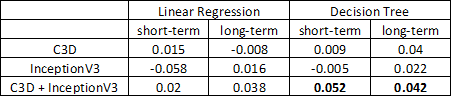

# Prediction of Test Results

## Importing Ground Truths

In [7]:
Ground_Truth_Test = pd.read_csv('/content/drive/MyDrive/CA684_Assignment/Test-set/Ground-truth_test/ground_truth_template.csv')
print(f'Test-Dataset : {Ground_Truth_Test.shape}')

Test-Dataset : (2000, 5)


## Extracting C3D and InceptionV3 Features

In [11]:
Test_C3D_Path = '/content/drive/MyDrive/CA684_Assignment/Test-set/C3D_test/'
Test_C3D_Feature = []
Test_C3D_Feature = C3D_Fetch(Test_C3D_Path)

100%|██████████| 2000/2000 [10:13<00:00,  3.26it/s]


In [12]:
np.save("/content/drive/MyDrive/Test_Extracted_Features/C3D_features_test.npy",Test_C3D_Feature)

In [121]:
Test_C3D_Feature = np.load("/content/drive/MyDrive/Test_Extracted_Features/C3D_features_test.npy")
Test_C3D_Feature= Test_C3D_Feature[:,0].reshape(-1, 1)
Test_C3D_Feature.shape

(2000, 1)

In [22]:
#DevSet Path
Test_Inception_Path = "/content/drive/MyDrive/CA684_Assignment/Test-set/Inception_test/"

#Extracting  Inception Features for Dev Set
Inception_Dataframe_Final = pd.DataFrame(columns = ['video', 'features'])
Inception_Dataframe_0 = pd.DataFrame(columns = ['video', 'features'])
Inception_Dataframe_56 = pd.DataFrame(columns = ['video', 'features'])
Inception_Dataframe_112 = pd.DataFrame(columns = ['video', 'features'])
Incep_File_0 = []
Incep_File_56 = []
Incep_File_112 = []
Inception_Files = os.listdir(Test_Inception_Path)
for Incep_File in tqdm(Inception_Files):
    if Incep_File.endswith(".txt"):
        Final_Path = os.path.join(Test_Inception_Path, Incep_File)
        array = Inception_Fetch(Final_Path)
        #Frame 56 for InceptionV3
        if "-56" in Incep_File:
          Incep_File.replace('-56','')
          Incep_File_56= Incep_File.replace(".txt",".webm")
          Inception_Dataframe_56 = Inception_Dataframe_56.append({'video': Incep_File_56, 'features': array}, ignore_index=True)
        elif "-0" in Incep_File:
          Incep_File.replace('-0','')
          Incep_File_0= Incep_File.replace(".txt",".webm")
          Inception_Dataframe_0 = Inception_Dataframe_0.append({'video': Incep_File_0, 'features': array}, ignore_index=True)
        elif "-112" in Incep_File:
          Incep_File.replace('-112','')
          Incep_File_112= Incep_File.replace(".txt",".webm")
          Inception_Dataframe_112 = Inception_Dataframe_112.append({'video': Incep_File_112, 'features': array}, ignore_index=True)
    else:
        break

Incept_Features_Test = Inception_Dataframe_112['features'].tolist()
Count = 0
for item in range(2000):
    Incept_Features_Test[Count] = np.append(Incept_Features_Test[Count],Inception_Dataframe_0['features'][Count],axis=0)
    Incept_Features_Test[Count] = np.append(Incept_Features_Test[Count],Inception_Dataframe_56['features'][Count],axis=0)
    Count = Count+1



100%|██████████| 6000/6000 [00:21<00:00, 275.14it/s]


In [23]:
np.save("/content/drive/MyDrive/Test_Extracted_Features/Inceptionv3_features_test.npy",Incept_Features_Test)

In [123]:
Incept_Features_Test = np.load("/content/drive/MyDrive/Test_Extracted_Features/Inceptionv3_features_test.npy")
Incept_Features_Test= Incept_Features_Test[:,0].reshape(-1, 1)
Incept_Features_Test.shape

(2000, 1)

## Apply Best Performing ML Algorithm C3D + InceptionV3


### Combining C3D and InceptionV3 test set

In [124]:
len(Test_C3D_Feature)

2000

In [125]:
Combine_C3D_InceptionV3_Test = []
Combine_C3D_InceptionV3_Test = Test_C3D_Feature.tolist()
Count = 0
for item in range(2000):
    Combine_C3D_InceptionV3_Test[Count] = np.append(Combine_C3D_InceptionV3_Test[Count],Incept_Features_Test[Count],axis=0)
    Count = Count+1

In [126]:
len(Combine_C3D_InceptionV3_Test)

2000

### Training Dev-set

In [136]:
X_Dev_Train = Combine_C3D_InceptionV3_Test
Y_Ground_Truth = Ground_Truth_Dev[['short-term_memorability','long-term_memorability']].values
print('X : '+ str(len(X_Dev_Train)))
print('Y : '+ str(Y_Ground_Truth.shape))
print('X_Train : ' + str(len(Combine_C3D_InceptionV3)))

X : 2000
Y : (6000, 2)
X_Train : 6000


### Applying Decision Tree Regression on Test C3D + InceptionV3

In [137]:
DTregressor_Test = DecisionTreeRegressor()
DTregressor_Test.fit(Combine_C3D_InceptionV3, Y_Ground_Truth)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [138]:
Test_Prediction = DTregressor_Test.predict(Combine_C3D_InceptionV3_Test)

Prediction_Dataframe = pd.DataFrame()
Prediction_Dataframe['short-term'] = Test_Prediction[:,0]
Prediction_Dataframe['long-term'] = Test_Prediction[:,1]
Prediction_Dataframe.head()

,short-term,long-term
0,0.983000,1.000000
1,0.836000,0.750000
2,0.867000,0.600000
3,0.944000,0.861000
4,0.860477,0.781417


In [139]:
Prediction_Dataframe.describe()

,short-term,long-term
count,2000.000000,2000.000000
mean,0.862588,0.779277
std,0.070322,0.128814
min,0.476000,0.300000
25%,0.830000,0.706000
50%,0.864000,0.781417
75%,0.919000,0.866625
max,0.985000,1.000000


# Exporting Results

In [148]:
Prediction_Dataframe.to_csv("/content/drive/MyDrive/Test_Extracted_Features/Rasika_Mehta_20210036_predictions.csv",index=False)